In [1]:
import os
import random
from tqdm import tqdm
import numpy as np
import pandas as pd

import torch
from torch.utils.data import Dataset

import evaluate
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from transformers import DataCollatorWithPadding
from transformers import TrainingArguments, Trainer

from sklearn.model_selection import train_test_split

In [2]:
SEED = 456
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

In [3]:
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
DEVICE

device(type='cuda')

In [4]:
BASE_DIR = os.getcwd()
DATA_DIR = os.path.join(BASE_DIR, '../data')
OUTPUT_DIR = os.path.join(BASE_DIR, '../output')

In [5]:
data = pd.read_csv(os.path.join(DATA_DIR, 'train.csv'))
dataset_train, dataset_valid = train_test_split(data, test_size=0.3, stratify=data['target'],random_state=SEED)

In [6]:
model_name = 'klue/bert-base'
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=7).to(DEVICE)
tokenizer = AutoTokenizer.from_pretrained(model_name)

Some weights of the model checkpoint at klue/bert-base were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at klue/bert-base and are newly initial

In [8]:
class BERTDataset(Dataset):
    def __init__(self, data, tokenizer):
        input_texts = data['text']
        targets = data['target']
        self.inputs = []
        self.labels = []
        
        for text, label in zip(input_texts, targets):
            tokenized_input = tokenizer(text, padding='max_length', truncation=True, return_tensors='pt')
            self.inputs.append(tokenized_input)
            self.labels.append(torch.tensor(label))
    
    def __getitem__(self, idx):
        return {
            'input_ids': self.inputs[idx]['input_ids'].squeeze(0),  
            'attention_mask': self.inputs[idx]['attention_mask'].squeeze(0),
            'labels': self.labels[idx].squeeze(0)
        }
    
    def __len__(self):
        return len(self.labels)

In [9]:
data_train = BERTDataset(dataset_train, tokenizer)
data_valid = BERTDataset(dataset_valid, tokenizer)

In [10]:
n,m=len(data_train),len(data_train[0]['input_ids'])
torch_embed,torch_label=torch.zeros(n, m),torch.zeros(n, 1)
for i in range(len(data_train)):
    torch_embed[i],torch_label[i]=data_train[i]['input_ids'],data_train[i]['labels']

## Dimension Reduction

In [11]:
n_components=3

### PCA

In [53]:
from sklearn.decomposition import PCA

pca = PCA(n_components=n_components)
printcipalComponents = pca.fit_transform(torch_embed)
df = pd.DataFrame(data=printcipalComponents, columns = ['pc1', 'pc2'])
df['target']=torch_label

### t-sne

In [12]:
from sklearn.manifold import TSNE

model = TSNE(n_components=n_components)
TSNEembedded = model.fit_transform(torch_embed)
df = pd.DataFrame(data=TSNEembedded, columns = ['pc1', 'pc2', 'pc3'])
df['target']=torch_label

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


## Visualization

In [13]:
df.head()

,pc1,pc2,pc3,target
0,8.261996,-4.691820,8.103653,2.0
1,10.199027,15.424244,-0.944459,0.0
2,13.798100,13.584923,-1.419800,3.0
3,-21.909899,4.365635,-1.301074,4.0
4,-9.979104,-7.651284,11.376699,6.0


### 2D

/tmp/ipykernel_120643/792402322.py:5: UserWarning: The palette list has more values (10) than needed (7), which may not be intended.
  sns.scatterplot(data=df, x="pc1", y="pc2", hue="target", legend='full', palette=palette)


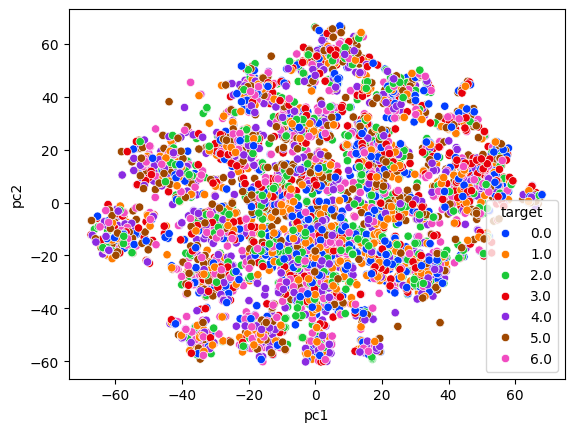

In [56]:
import seaborn as sns
from matplotlib import pyplot as plt

palette = sns.color_palette("bright", 10)
sns.scatterplot(data=df, x="pc1", y="pc2", hue="target", legend='full', palette=palette)
plt.show()

### 3D

In [14]:
import seaborn as seaborn
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

seaborn.set_style("darkgrid")

fig = plt.figure(figsize=(6,6))

axes = Axes3D(fig)
x,y,z=df['pc1'].tolist(),df['pc2'].tolist(),df['pc3'].tolist()
co=df['target'].tolist()
axes.scatter(x, y, z, c=co, marker='o')

axes.set_xlabel("x")
axes.set_ylabel("y")
axes.set_zlabel("z")
plt.show()

<Figure size 600x600 with 0 Axes>

In [19]:
def plot_scatter3D(dataframe, sampling=10_000, save=False, fname='scatter_plot'):
    color_map = ['#8B0000', '#FF0000', '#BDB76B', '#7CFC00', '#008080', '#4169E1', '#FF69B4']
    if sampling:
        idx = np.random.randint(0, len(dataframe), sampling)    
        samples = dataframe.iloc[idx]
    else:
        samples = dataframe.copy()
    
    x = df['pc1']
    y = df['pc2']
    z = df['pc3']
    label = df['target']
    
    fig = plt.figure(figsize=(9, 6))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(x, y, z, color=label.apply(lambda x: color_map[label]), alpha=0.5)
    
    if save:
        plt.savefig(os.path.join('', f'{fname}.png'), dpi=200)
    plt.show()
    

TypeError: list indices must be integers or slices, not Series

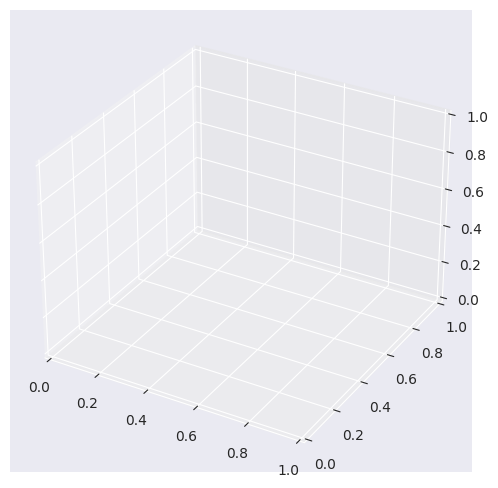

In [20]:
plot_scatter3D(df)